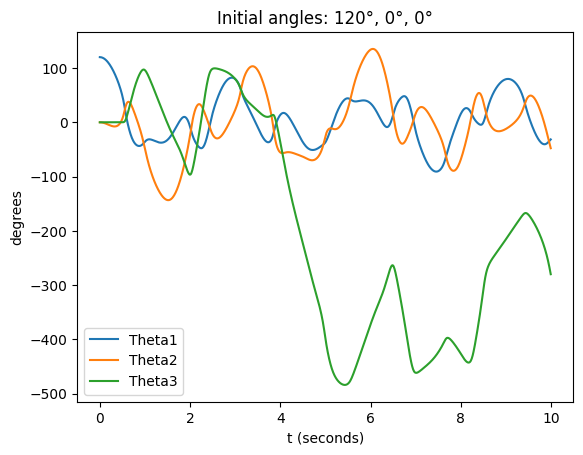

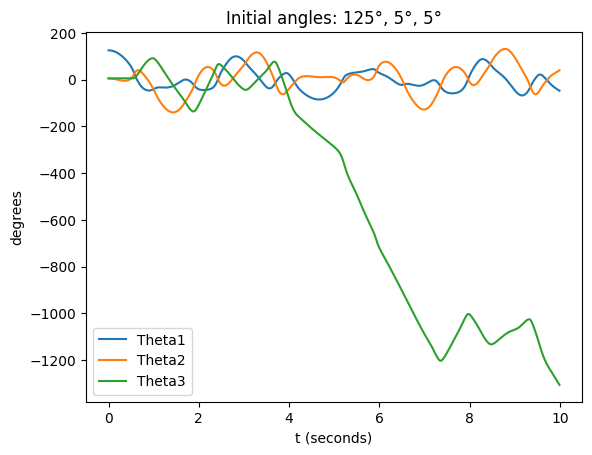

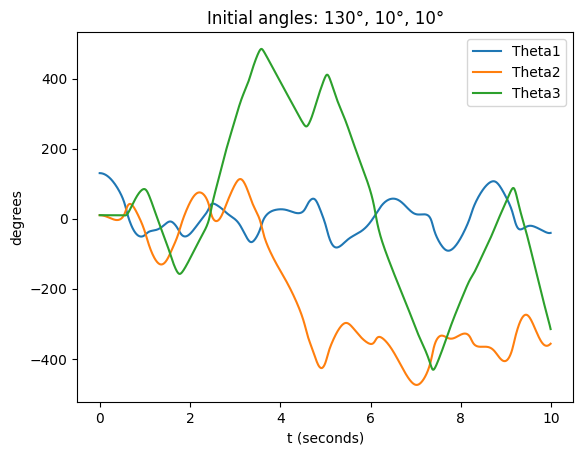

In [33]:
from __future__ import division, print_function
from math import sin, cos, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from math import sin, cos, pi
import numpy as np
import matplotlib.pyplot as plt

g = 9.81
l1 = 1
l2 = 1
l3 = 1
m1 = 1.0
m2 = 1.0
m3 = 1.0

# Triple pendulum derivative function
def f(q, t):
    # Define useful mass combinations
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012 / 4

    # Define useful sines
    sin0 = np.sin(q[0])
    sin1 = np.sin(q[2])
    sin2 = np.sin(q[4])

    # Define useful sine and cosine of differences
    cos01 = np.cos(q[0] - q[2])
    cos02 = np.cos(q[0] - q[4])
    cos12 = np.cos(q[2] - q[4])
    sin01 = np.sin(q[0] - q[2])
    sin02 = np.sin(q[0] - q[4])
    sin12 = np.sin(q[2] - q[4])

    # Define useful recurrent patterns
    r1 = m12 * cos01 * cos02 - m012 * cos12
    r2 = m012 - m12 * (cos01) ** 2
    r3 = -m012 + m3 * (cos02) ** 2

    # Define parts of the first equation
    od1_1 = 4*m3*m12
    od1_2 = r1*cos01 + r2*cos02
    od1_3 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od1_4 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2
    od1_5 = -m3*m12*( -cos02 + np.cos(q[0]-2*q[2]+q[4]) )**2 * m012
    od1_6 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od1_7 = m3*r1**2 + m12*r3*r2

    # Define parts of the second equation
    od2_1 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od2_2 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od2_3 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2

    # Define parts of the thirds equation
    od3_1 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od3_2 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od3_3 = g*m2*sin1 + g*m3*sin1 - l1*m2*sin01*q[1]**2 - l1*m3*sin01*q[1]**2 + l3*m3*sin12*q[5]**2

    # ThetaDot equations
    td1 = q[1]
    td2 = q[3]
    td3 = q[5]

    # OmegaDot equations
    od1 = mf * ( od1_1 * od1_2 * od1_3 * r2 - 4 * ( -m3 * od1_2 * r1 + ( m3 * r1**2 + m12 * r3 * r2 ) * cos01 ) * od1_4 - ( od1_5 + 4*m3*r1**2 + 4*m12*r3*r2 ) * od1_6 ) / ( l1 * od1_7 * m012 * r2)
    od2 = ( -m3 * r1 * m012 * od2_1 * r2 - ( m3 * ( r1*cos01 + r2*cos02 ) * r1 - ( m3*r1**2 + m12*r3*r2 ) * cos01 ) * od2_2 + m012*r3*r2*od2_3 ) / ( l2 * od1_7 * r2 )
    od3 = -( m12 * (od1_2) * (od3_1) + m12 * m012 * (od3_2) * r2 - r1*m012 * od3_3 ) / ( l3 * ( m3*r1**2 + m12*r3*r2 ) )

    return np.array([td1, od1, td2, od2, td3, od3])

# Time parameters
a = 0.0
b = 10
N = 1000
h = (b - a) / N

# Function to simulate the triple pendulum
def simulate_triple_pendulum(theta1_deg, theta2_deg, theta3_deg):
    tpoints = np.arange(a, b, h)
    theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
    theta2_points = np.zeros_like(tpoints)
    theta3_points = np.zeros_like(tpoints)

    # Convert initial conditions to radians
    q = np.array([np.radians(theta1_deg), 0, np.radians(theta2_deg), 0, np.radians(theta3_deg), 0], float)

    # Runge-Kutta 4th order method loop
    for i, t in enumerate(tpoints):
        theta1_points[i] = np.degrees(q[0])  # Convert to degrees
        theta2_points[i] = np.degrees(q[2])
        theta3_points[i] = np.degrees(q[4])

        k1 = h * f(q, t)
        k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(q + k3, t + h)
        q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return tpoints, theta1_points, theta2_points, theta3_points

# Testing a range of initial angles
initial_angles = [[120, 0, 0], [125, 5, 5], [130, 10, 10]]
all_data = []  # Hold data for all sets of initial angles

for angles in initial_angles:
    tpoints, theta1_points, theta2_points, theta3_points = simulate_triple_pendulum(angles[0], angles[1], angles[2])

    plt.plot(tpoints[0:1000], theta1_points[0:1000], label=f'Theta1')
    plt.plot(tpoints[0:1000], theta2_points[0:1000], label=f'Theta2')
    plt.plot(tpoints[0:1000], theta3_points[0:1000], label=f'Theta3')
    plt.title(f'Initial angles: {angles[0]}°, {angles[1]}°, {angles[2]}°')
    plt.xlabel("t (seconds)")
    plt.ylabel("degrees")
    plt.legend()
    plt.show()

    # Store data
    data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
    all_data.append(data)

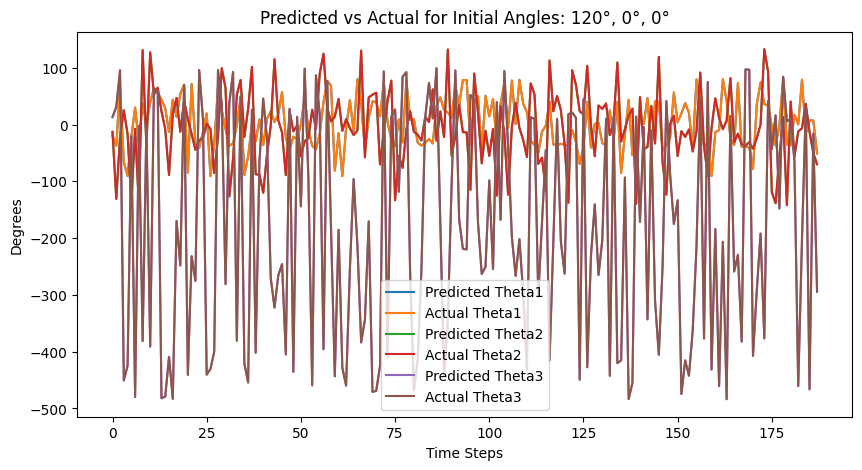

RMSE: 0.01138163232144387763
R^2 Score: 0.99999997695579645463



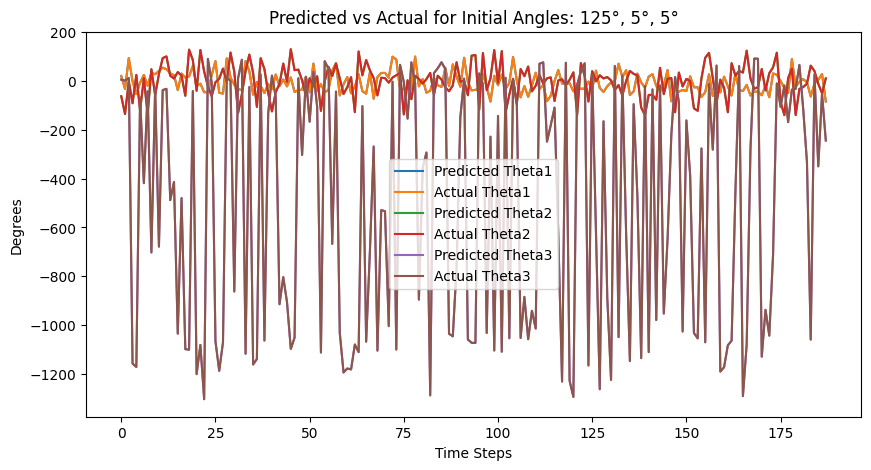

RMSE: 0.01541282192045015549
R^2 Score: 0.99999994690556703869



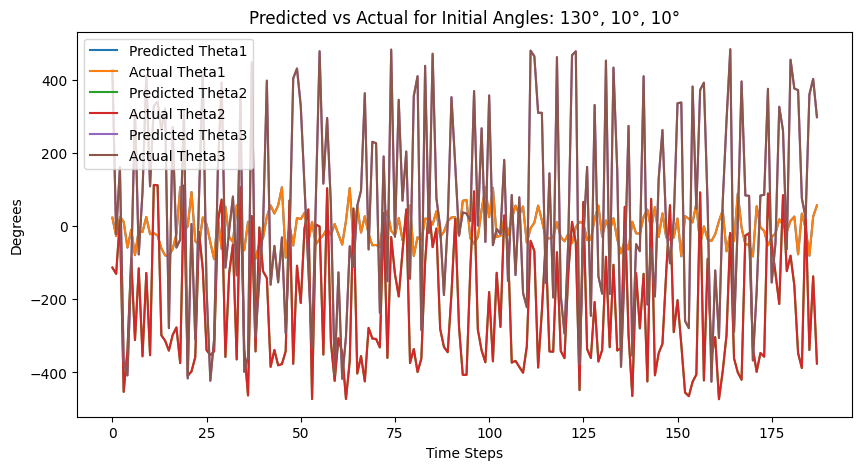

RMSE: 0.06677472911889643925
R^2 Score: 0.99999977390435201841



In [34]:
# Hyperparameters
SEQ_LENGTH = 64
POLY_DEGREE = 2

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

for idx, angles in enumerate(initial_angles):
    actual_data = all_data[idx]

    # Create sequences
    X, y = create_sequences(actual_data, SEQ_LENGTH)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))

    # Fit the scalers on the training data
    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 3 * SEQ_LENGTH))
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, 3 * SEQ_LENGTH))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Apply polynomial feature mapping
    poly = PolynomialFeatures(degree=POLY_DEGREE)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Create and train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_scaled)
    predictions_scaled = model.predict(X_test_poly)

    # Inverse transform the scaled predictions and actual values
    predictions_inverse = scaler_y.inverse_transform(predictions_scaled)
    y_test_inverse = scaler_y.inverse_transform(y_test_scaled)

    # Plot the predicted vs actual values for each angle (Theta1, Theta2, Theta3)
    plt.figure(figsize=(10, 5))
    plt.plot(predictions_inverse[:, 0], label='Predicted Theta1')
    plt.plot(y_test_inverse[:, 0], label='Actual Theta1')
    plt.plot(predictions_inverse[:, 1], label='Predicted Theta2')
    plt.plot(y_test_inverse[:, 1], label='Actual Theta2')
    plt.plot(predictions_inverse[:, 2], label='Predicted Theta3')
    plt.plot(y_test_inverse[:, 2], label='Actual Theta3')
    plt.title(f'Predicted vs Actual for Initial Angles: {angles[0]}°, {angles[1]}°, {angles[2]}°')
    plt.xlabel('Time Steps')
    plt.ylabel('Degrees')
    plt.legend()
    plt.show()

    # Calculate and display RMSE and R^2 scores
    rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
    r2 = r2_score(y_test_inverse, predictions_inverse)
    print(f'RMSE: {rmse:.20f}')
    print(f'R^2 Score: {r2:.20f}')
    print()